# US Industrial Production
Industrial production encompasses the manufacturing of durable and non-durable goods (e.g., food, textiles), mining (including quarrying, and oil and gas extraction), and the production of utilities (electricity and natural gas). Different countries have varying shares of industrial production in their GDP, with developed economies tending to have a smaller portion. In the US, industrial production makes up about 14.1% of the GDP. This share has been steadily declining, primarily due to the shrinkage of the manufacturing industry, which has decreased by 5% since 1996 and now accounts for 10.9% of the GDP.

Since industrial production is measured based on an index chained to a particular year, it reflects _real_ changes in production.

In this notebook I analyze overall trends in US Industrial production, including trends for individual industry groups.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [3]:
INDPRO_SICS_COLUMN_NAME = 'Manufacturing'
INDPRO_MINE_COLUMN_NAME = 'Mining'
INDPRO_UTIL_COLUMN_NAME = 'Utilities'

## Share of Industrial production in US GDP
I calculate a share of major industry groups by looking at their value added to GDP.

In [4]:
indpro_gdp_share = web.get_data_fred(['VAPGDPMA', 'VAPGDPM', 'VAPGDPU'], start=report_start, end=report_end) / 100.
indpro_gdp_share['Total'] = indpro_gdp_share.sum(axis=1)
indpro_gdp_share = indpro_gdp_share.rename(
    columns={'VAPGDPMA': INDPRO_SICS_COLUMN_NAME,
             'VAPGDPM': INDPRO_MINE_COLUMN_NAME, 'VAPGDPU': INDPRO_UTIL_COLUMN_NAME})
indpro_gdp_share = indpro_gdp_share.iloc[:, [-1, 0, 1, 2]]

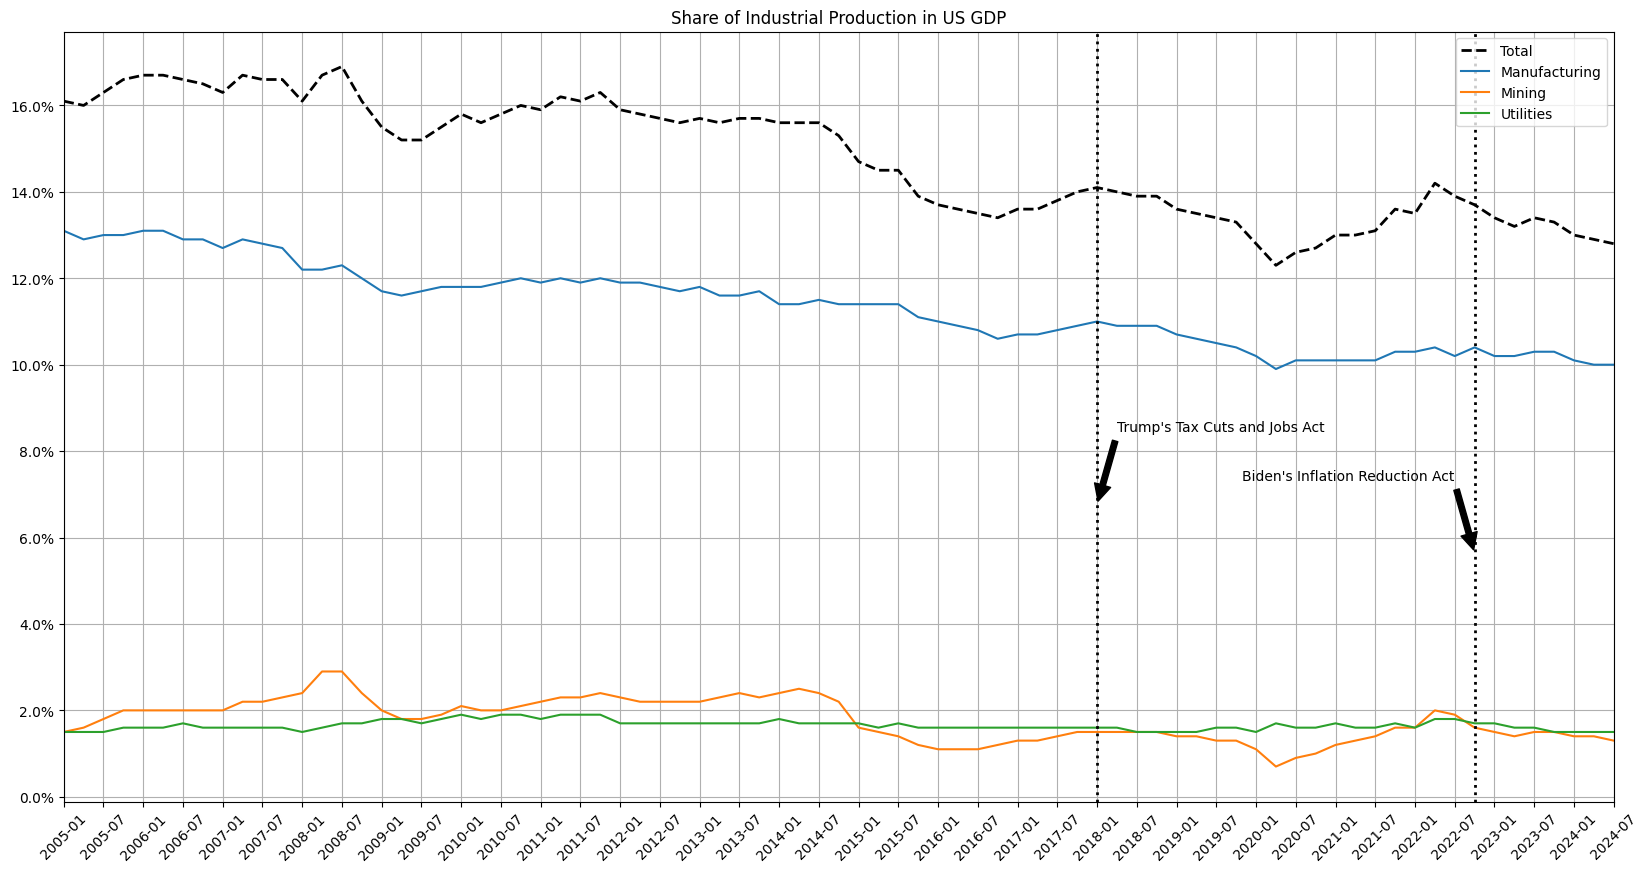

In [5]:
GRAPH_TITLE_INDPRO_GDP_SHARE = 'Share of Industrial Production in US GDP'
TAX_CUTS_DATE = '2018-1-1'
IRA_DATE = '2022-10-1' # Signed into law on August 16, 2022.
ax = indpro_gdp_share.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDPRO_GDP_SHARE,
             xticks=indpro_gdp_share.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indpro_gdp_share.iloc[:,1:].plot(ax=ax, grid=True, xticks=indpro_gdp_share.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
x1 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(TAX_CUTS_DATE)]
y1 = indpro_gdp_share.iloc[:,0].max() / 2.5
x2 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(TAX_CUTS_DATE) + 1]
y2 = y1 + indpro_gdp_share.iloc[:,0].max() / 10
ax.axvline(x1, color='k', linestyle=':', linewidth=2)

x3 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(IRA_DATE)]
x4 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(IRA_DATE) - 1]
y3 = indpro_gdp_share.iloc[:,0].max() / 3
y4 = y3 + indpro_gdp_share.iloc[:,0].max() / 10
ax.axvline(x3, color='k', linestyle=':', linewidth=2)

ax.annotate('Trump\'s Tax Cuts and Jobs Act',
            xy=(x1, y1), xytext=(x2, y2),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Biden\'s Inflation Reduction Act',
            xy=(x3, y3), xytext=(x4, y4),
            arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right')
ax.legend(loc='upper right')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_gdp_share.index[::2])))

### High-level Composition of US Industrial Production

In [6]:
indpro_components = web.get_data_fred(['INDPRO', 'IPMANSICS', 'IPMINE', 'IPUTIL'], start=report_start, end=report_end)

In [7]:
GRAPH_TITLE_INDPRO_COMPOSITION = 'High-level Composition of US Industrial Poduction'
LEFT_Y_AXIS_LABEL = 'Sum of individual industrial production indicies'
indpro_components_stacked = indpro_components.rename(
    columns={'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME})

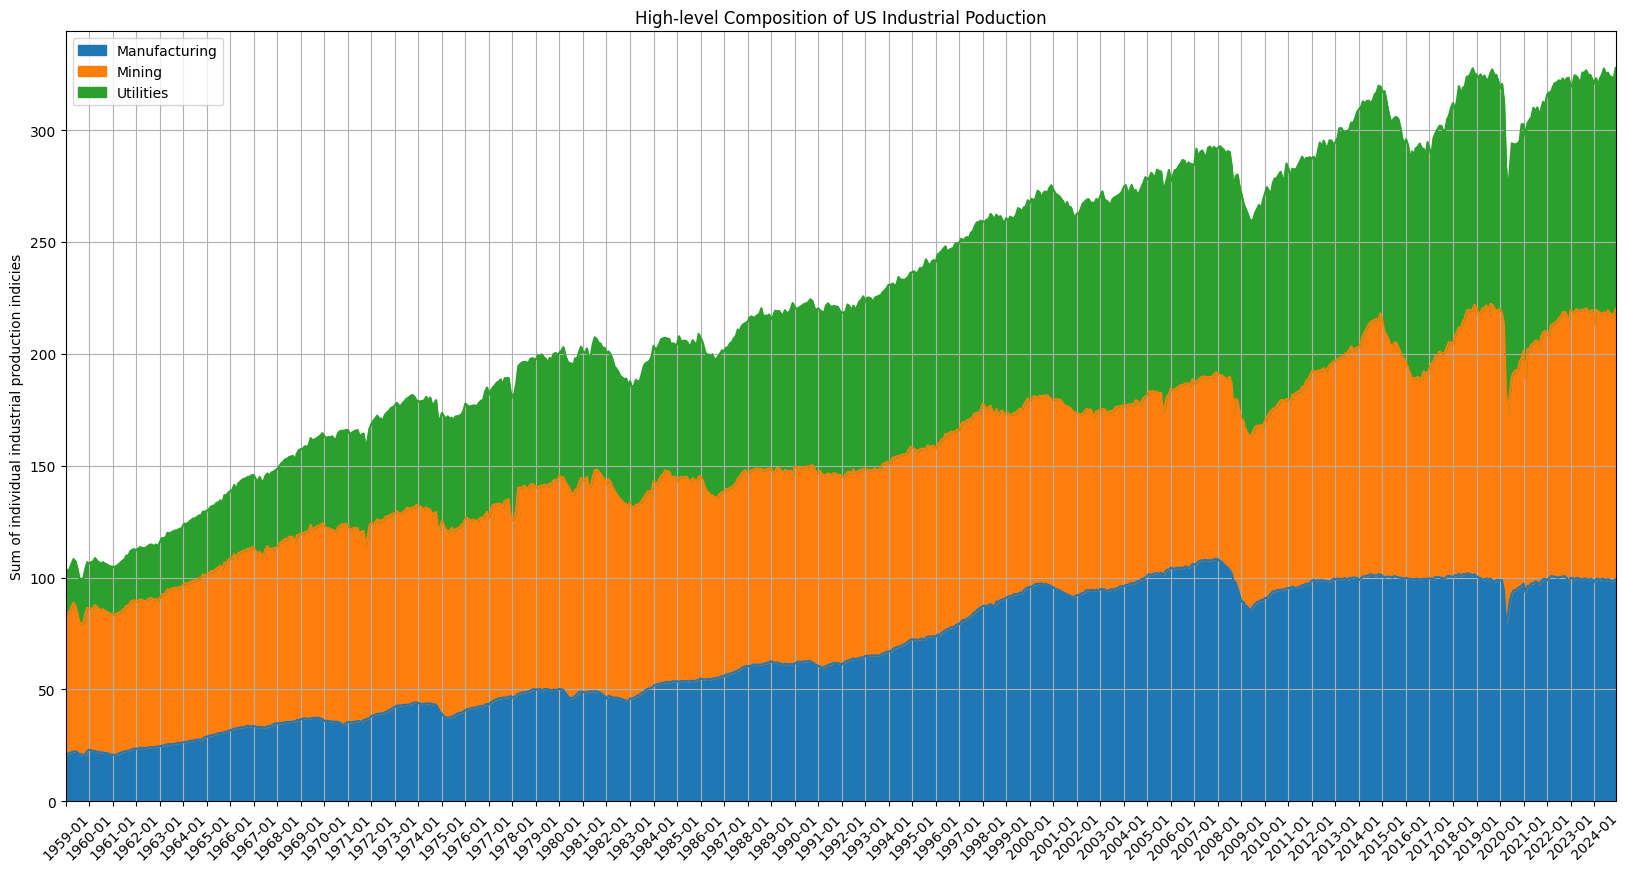

In [8]:
ax = indpro_components_stacked.iloc[:, 1:].plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                          xticks=indpro_components_stacked.index[::12], xlabel='', rot=45,
                                                    ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked.index[::12])))

In [9]:
# Converting to percentages by dividing by total
indpro_components_stacked_pct = indpro_components_stacked.iloc[:,1:].divide(
    indpro_components_stacked.iloc[:,1:].sum(axis=1), axis=0)

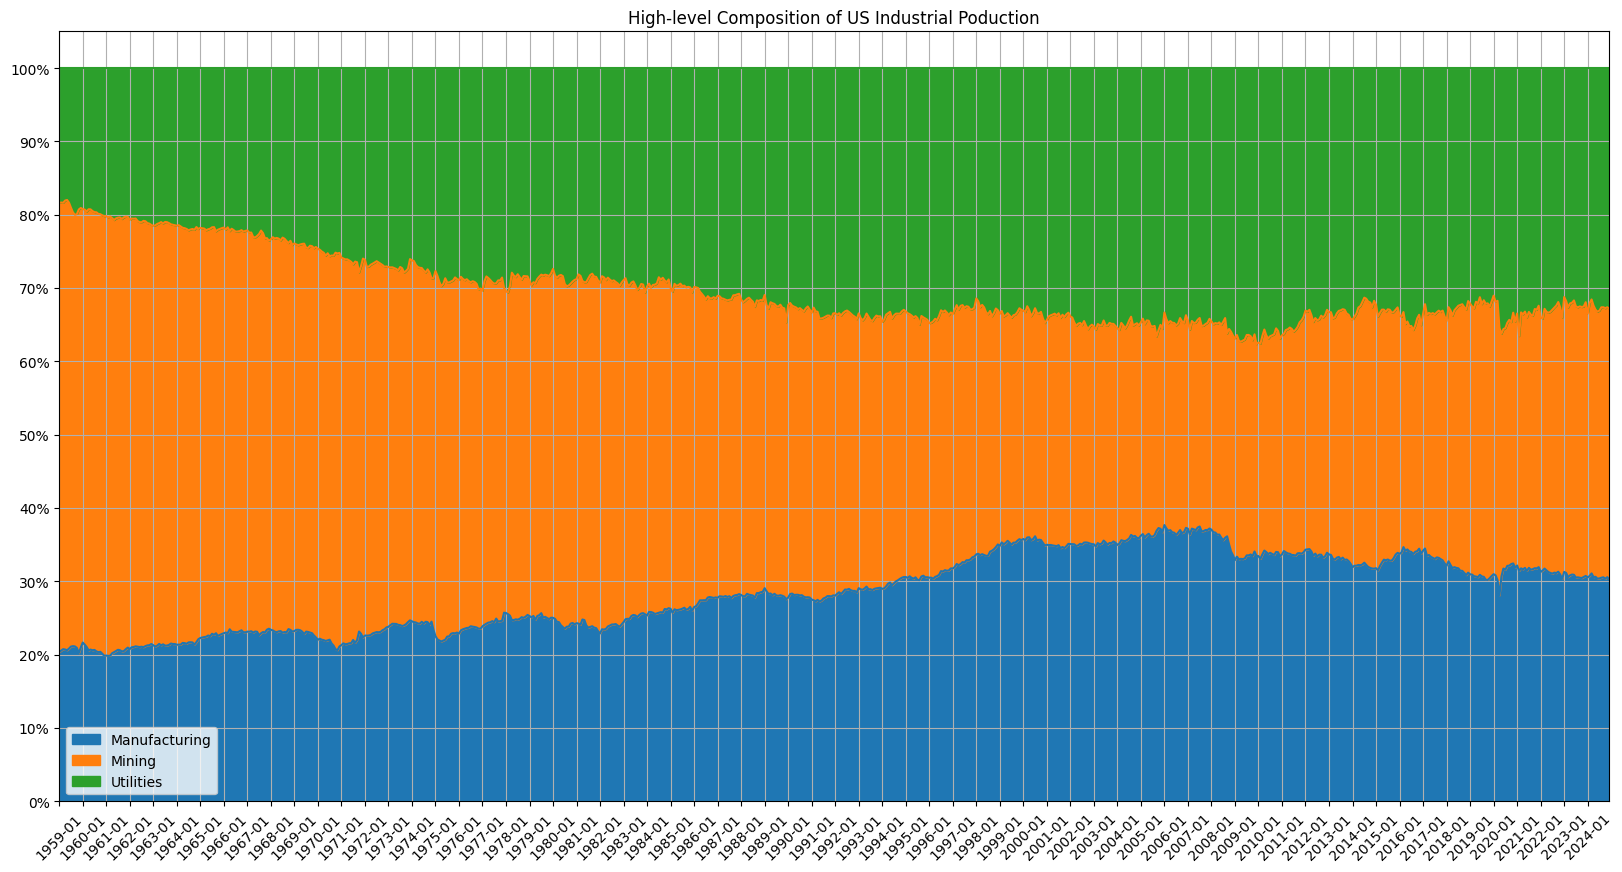

In [10]:
ax = indpro_components_stacked_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                              xticks=indpro_components_stacked_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked_pct.index[::12])))

### Annual Percentage Changes in Main Components of US Industrial Production

When calculating annual percentage changes I compare output in a given month with the corresponding month 12 months earlier. Some economists, when calculating annual percentage changes in industrial production in a given year, find it more accurate to look at the total production in a given year. If you wish to use this approach, please use  `indpro_components_over_12_months` instead of `indpro_components`.

In [11]:
INDPRO_COLUMN_NAME = 'Industrial Production Annual Percentage Change'
INDPRO_SICS_COLUMN_NAME = 'Manufacturing Annual Percentage Change'
INDPRO_MINE_COLUMN_NAME = 'Mining Annual Percentage Change'
INDPRO_UTIL_COLUMN_NAME = 'Utilities Annual Percentage Change'
GRAPH_TITLE_INDPRO_COMPONENTS = 'Annual Percentage Changes in Main Components of US Industrial Production'
GRAPH_TITLE_LABOR_PROD = 'US Labor Productivity in Manufacturing: Output per Hour (2012=100)'
GRAPH_TITLE_LABOR_PROD_PCT = 'US Labor Productivity in Manufacturing: Annual percentage changes in output'
MEAN_LEVEL_OF_LABOR_PROD_PCT = 'Mean level of annual labour productivity growth in manufacturing'
indpro_components.rename(
    columns={'INDPRO': INDPRO_COLUMN_NAME, 'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME},
    inplace=True)

In [12]:
# When calculating annual parcentage changes over industrial production in the whole year,
# I need to filter out years that are not yet complete
mask = indpro_components.iloc[:,0].groupby(indpro_components.index.year).count() == 12
full_years = mask.index[mask == True]
indpro_components_over_12_months = indpro_components.loc[
    indpro_components.index.year.isin(mask.index[mask == True])].resample('YS-JAN').sum().pct_change().dropna()

# Measuring growth YTD with the corresponding intervals in previous years.
month = indpro_components.index[-1].month
indpro_components_ytd = indpro_components.loc[indpro_components.index.month <= month]
indpro_components_ytd = indpro_components_ytd.resample('YS-JAN').sum().pct_change().dropna()

# Converting to annual percentage changes (changes from the corresponding month a year ago)
indpro_components.update(indpro_components.pct_change(12))
indpro_components = indpro_components.loc['2003':]

In [13]:
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
indpro_components.loc['2020-01':]

,Industrial Production Annual Percentage Change,Manufacturing Annual Percentage Change,Mining Annual Percentage Change,Utilities Annual Percentage Change
DATE,,,,
2020-01-01,-1.9569%,-1.8166%,0.8924%,-5.1943%
2020-02-01,-1.1216%,-1.1385%,1.1358%,-2.7242%
2020-03-01,-5.0859%,-5.4862%,0.2625%,-6.8350%
2020-04-01,-17.2023%,-19.5173%,-14.5872%,-2.4154%
2020-05-01,-16.0195%,-16.0354%,-25.8359%,-5.4388%
...,...,...,...,...
2024-08-01,-0.0792%,-0.1373%,0.1717%,0.0345%
2024-09-01,-0.6884%,-0.6039%,-1.3128%,-0.4729%
2024-10-01,-0.4803%,-0.6005%,-0.4365%,0.2352%


#### Growth of total production in the whole calendar year

In [14]:
indpro_components_over_12_months

,Industrial Production Annual Percentage Change,Manufacturing Annual Percentage Change,Mining Annual Percentage Change,Utilities Annual Percentage Change
DATE,,,,
1960-01-01,2.2583%,2.1926%,1.7289%,6.9705%
1961-01-01,0.6654%,0.3382%,0.7553%,5.6056%
1962-01-01,8.3341%,8.7846%,2.8559%,7.5693%
1963-01-01,6.1279%,6.2510%,4.1215%,6.8940%
1964-01-01,6.7322%,6.8667%,4.1083%,8.5577%
...,...,...,...,...
2020-01-01,-7.1343%,-6.5315%,-14.6707%,-2.8923%
2021-01-01,4.3901%,4.9415%,3.1995%,2.0072%
2022-01-01,3.4368%,2.6747%,7.4955%,3.0345%


#### Growth of total production YTD
Here I compare the growth over the passed months of the current year with the corresponding period of the previous year.

In [15]:
indpro_components_ytd

,Industrial Production Annual Percentage Change,Manufacturing Annual Percentage Change,Mining Annual Percentage Change,Utilities Annual Percentage Change
DATE,,,,
1960-01-01,2.2583%,2.1926%,1.7289%,6.9705%
1961-01-01,0.6654%,0.3382%,0.7553%,5.6056%
1962-01-01,8.3341%,8.7846%,2.8559%,7.5693%
1963-01-01,6.1279%,6.2510%,4.1215%,6.8940%
1964-01-01,6.7322%,6.8667%,4.1083%,8.5577%
...,...,...,...,...
2020-01-01,-7.1343%,-6.5315%,-14.6707%,-2.8923%
2021-01-01,4.3901%,4.9415%,3.1995%,2.0072%
2022-01-01,3.4368%,2.6747%,7.4955%,3.0345%


### Zooming in on the current decade

In the below graph I compare industrial production in a given month with that of the same month a year earlier.

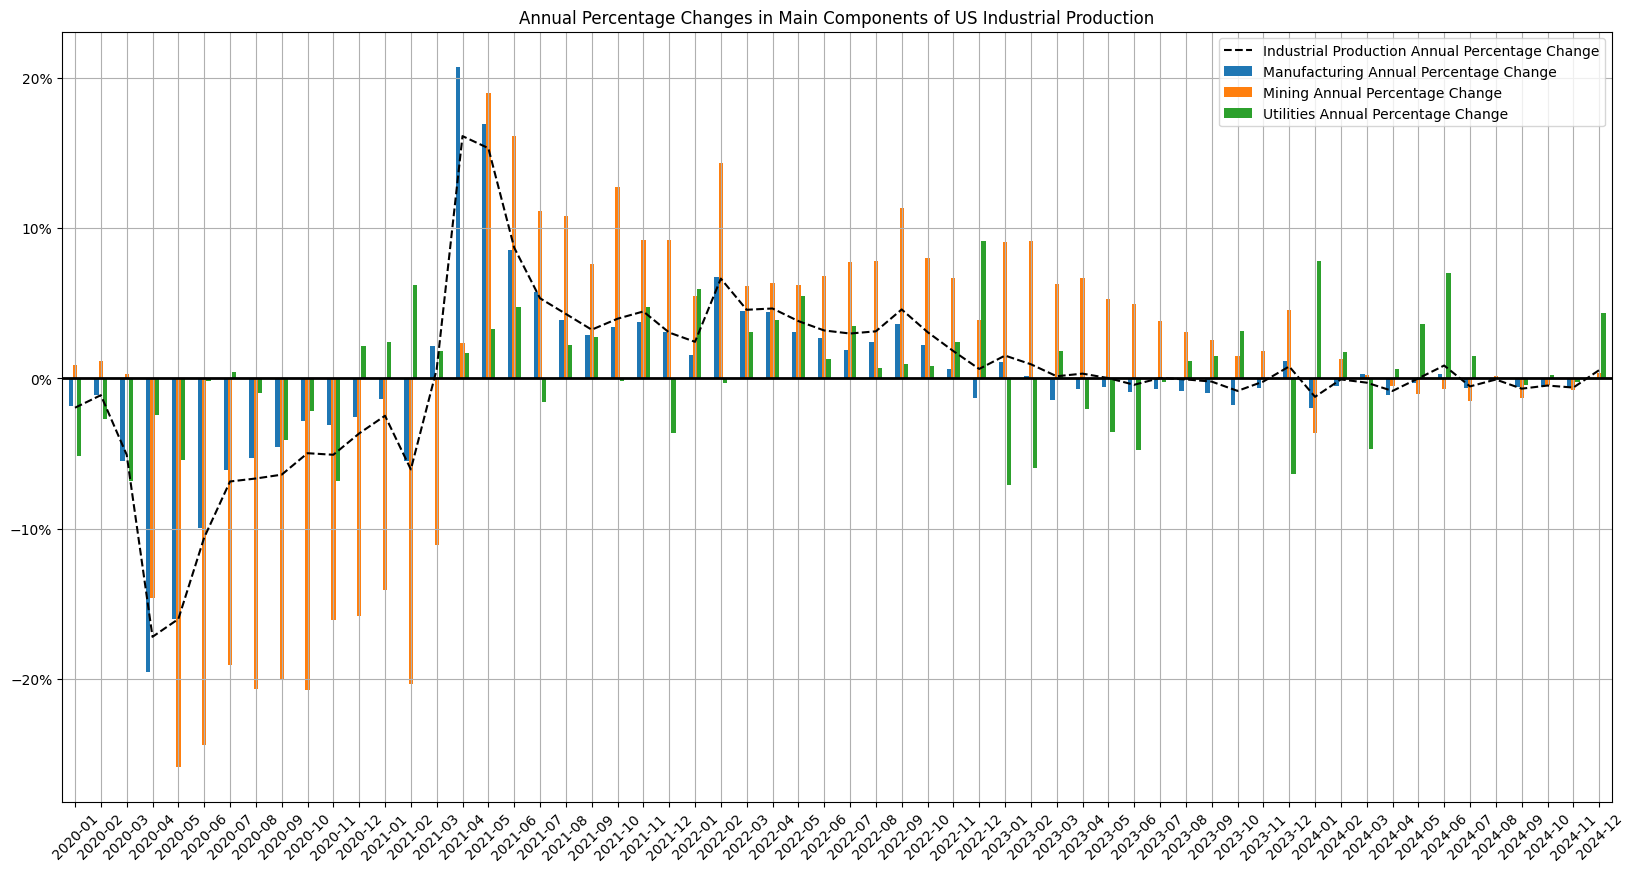

In [16]:
dt_from = date(2020, 1, 1)
indpro_components_recent = indpro_components.loc[dt_from:]
ax = indpro_components_recent.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
indpro_components_recent.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_recent.index)))

Below, I compare industrial production for the entire year with that of the previous year. For the past months of the current year, I compare industrial production in these months with the corresponding period of the previous year.

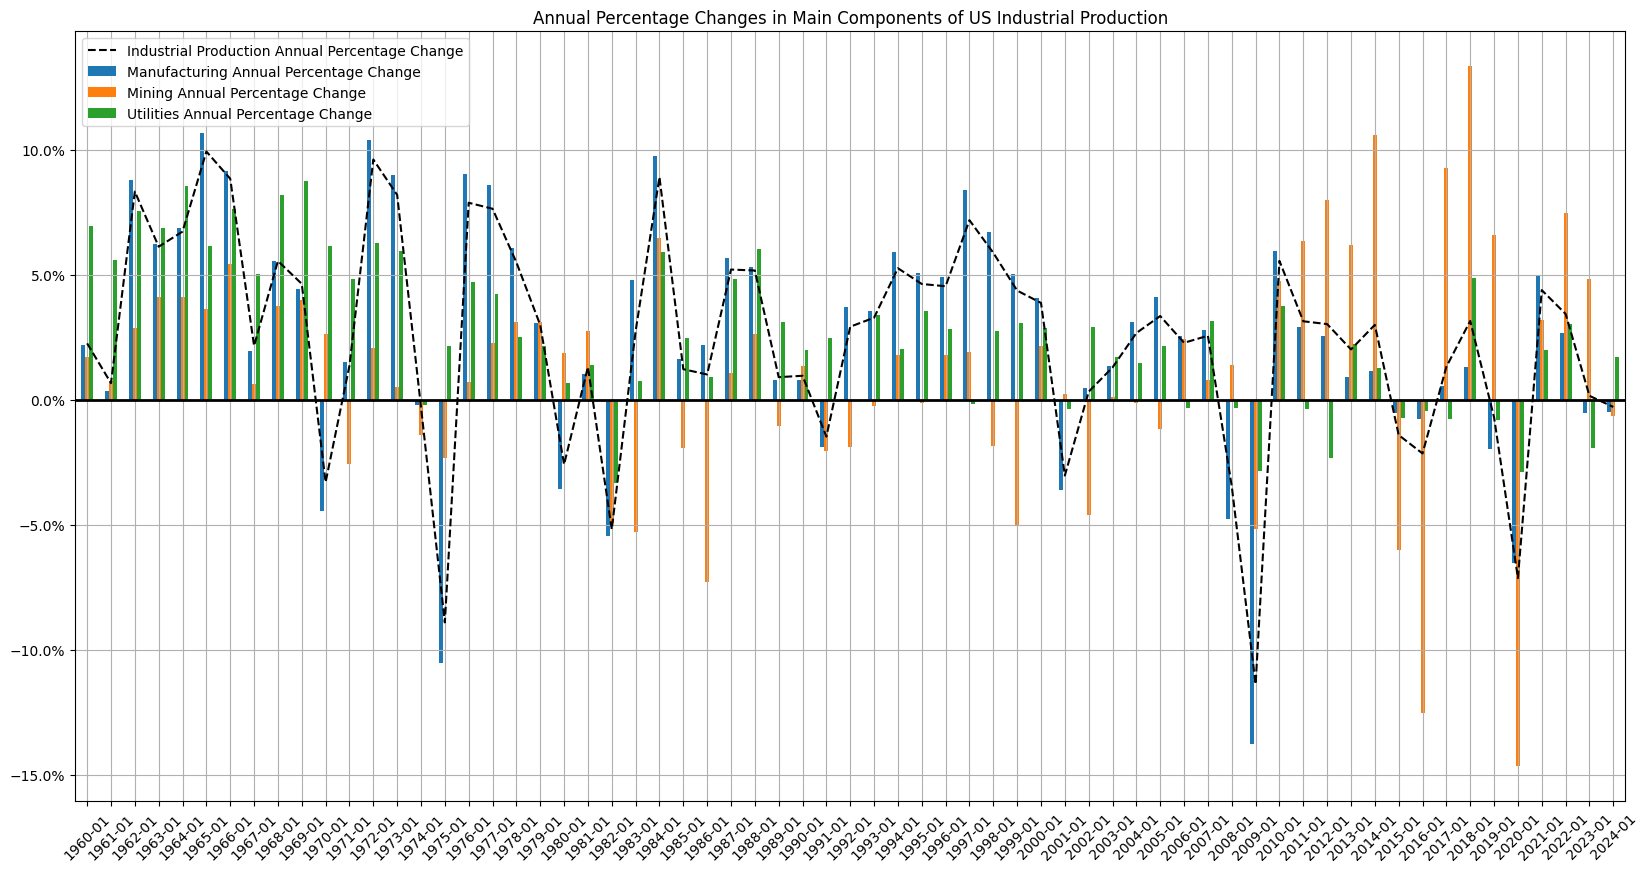

In [60]:
ax = indpro_components_ytd.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPONENTS + ' YTD',
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
indpro_components_ytd.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_ytd.index)))

### Capacity Utilization of Main Components of US Industrial Production

In [18]:
indpro_utilization = web.get_data_fred(['TCU', 'CUMFNS', 'CAPUTLG21S', 'CAPUTLG2211A2S'], start=report_start, end=report_end) / 100.
dt_from = date(2018, 1, 1)
indpro_utilization = indpro_utilization.loc[dt_from:]

In [19]:
INDPRO_TOTAL_CU_COLUMN_NAME = 'Total Capacity Utilization'
INDPRO_SICS_CU_COLUMN_NAME = 'Manufacturing Capacity Utilization'
INDPRO_MINE_CU_COLUMN_NAME = 'Mining Capacity Utilization'
INDPRO_UTIL_CU_COLUMN_NAME = 'Utilities Capacity Utilization'
GRAPH_TITLE_INDPRO_CU = 'US Industrial Production Capacity Utilization'
indpro_utilization.rename(
    columns={'TCU': INDPRO_TOTAL_CU_COLUMN_NAME, 'CUMFNS': INDPRO_SICS_CU_COLUMN_NAME,
             'CAPUTLG21S': INDPRO_MINE_CU_COLUMN_NAME, 'CAPUTLG2211A2S': INDPRO_UTIL_CU_COLUMN_NAME},
    inplace=True)

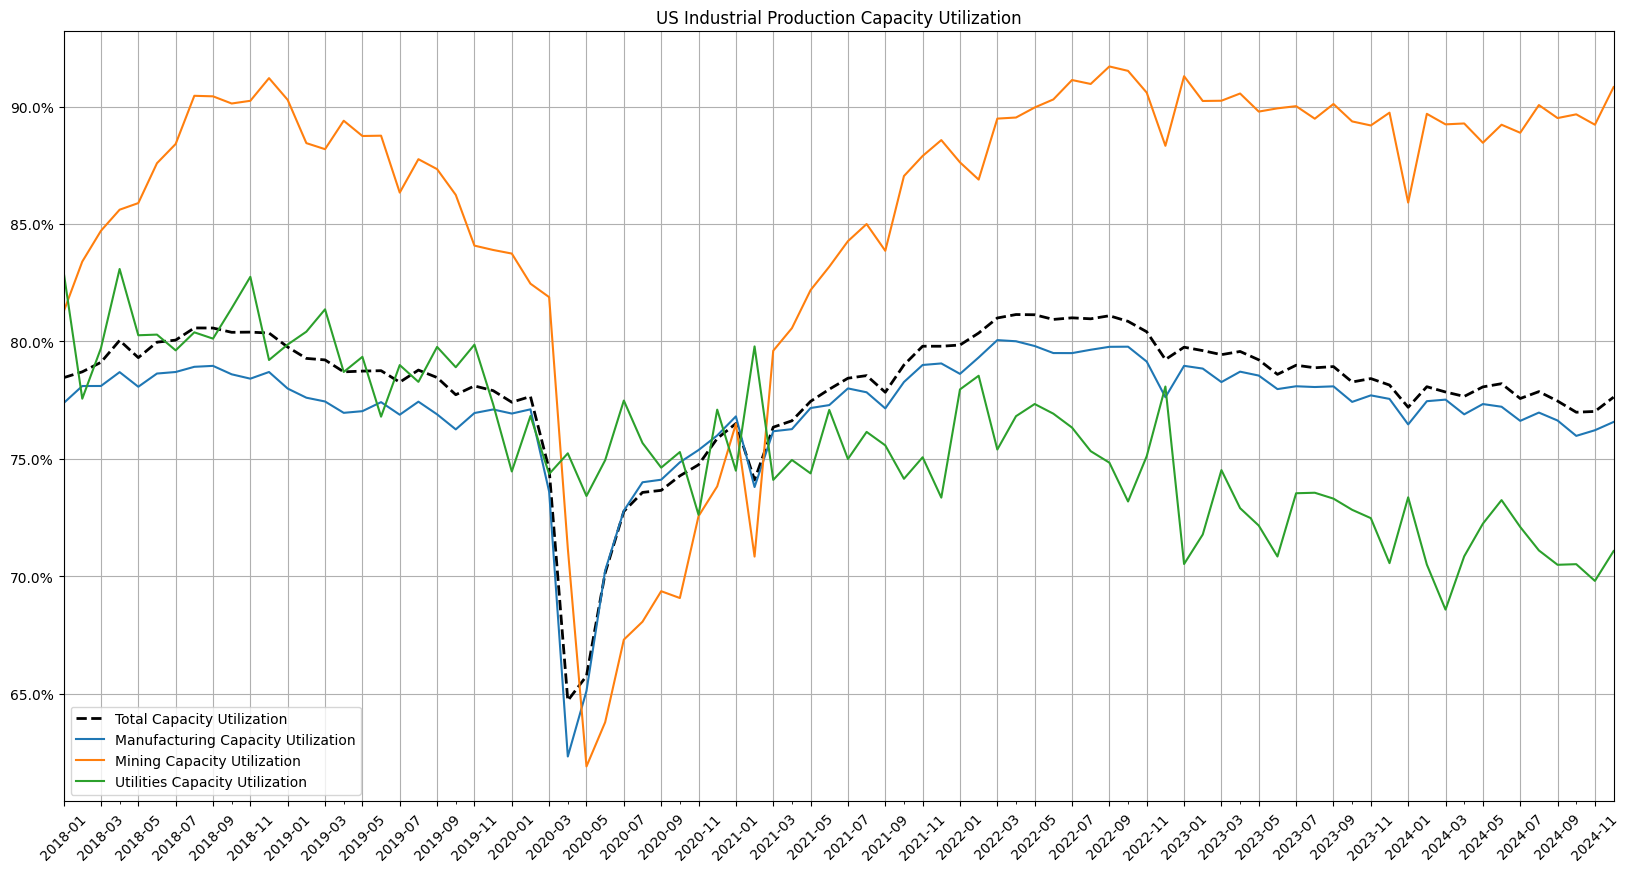

In [20]:
ax = indpro_utilization.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDPRO_CU,
             xticks=indpro_utilization.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indpro_utilization.iloc[:,1:].plot(ax=ax, grid=True, xticks=indpro_utilization.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_utilization.index[::2])))

In [21]:
indpro_utilization

,Total Capacity Utilization,Manufacturing Capacity Utilization,Mining Capacity Utilization,Utilities Capacity Utilization
DATE,,,,
2018-01-01,78.4548%,77.3713%,81.2630%,82.9723%
2018-02-01,78.7047%,78.0999%,83.4017%,77.5602%
2018-03-01,79.1096%,78.1015%,84.7136%,79.7127%
2018-04-01,80.0436%,78.6920%,85.6118%,83.0862%
2018-05-01,79.3092%,78.0687%,85.8938%,80.2628%
...,...,...,...,...
2024-08-01,77.8612%,76.9687%,90.0699%,71.0957%
2024-09-01,77.4603%,76.6304%,89.5160%,70.4839%
2024-10-01,76.9837%,75.9762%,89.6747%,70.5098%


#### Average capacity utilization YTD
Let's take a look at average capacity utilization YTD and in the corresponding YTD months of previous years.

In [22]:
indpro_utilization_ytd = indpro_utilization.loc[indpro_utilization.index.month <= month]
indpro_utilization_ytd = indpro_utilization.resample('YS-JAN').mean().dropna()
indpro_utilization_ytd

,Total Capacity Utilization,Manufacturing Capacity Utilization,Mining Capacity Utilization,Utilities Capacity Utilization
DATE,,,,
2018-01-01,79.8278%,78.4375%,87.4500%,80.6155%
2019-01-01,78.6402%,77.1618%,87.4594%,79.1345%
2020-01-01,72.9218%,72.7009%,72.0918%,75.1662%
2021-01-01,77.6976%,77.2330%,82.4596%,75.3379%
2022-01-01,80.6650%,79.3970%,89.8426%,76.3181%
2023-01-01,78.9837%,78.1839%,90.0024%,72.4112%
2024-01-01,77.6289%,76.8215%,89.1716%,71.1497%


## Zooming in on the Manufacturing Industry Group

### GDP Share of Durable and Nondurable Manufacturing industry groups

In [23]:
INDPRO_DM_COLUMN_NAME = 'Durable Manufacturing'
INDPRO_NDM_COLUMN_NAME = 'Nondurable Manufacturing'

In [24]:
manuf_gdp_share = web.get_data_fred(['VAPGDPMA', 'VAPGDPMD', 'VAPGDPMN'], start=report_start, end=report_end) / 100.
manuf_gdp_share = manuf_gdp_share.rename(
    columns={'VAPGDPMA': 'Total Manufacturing',
             'VAPGDPMD': INDPRO_DM_COLUMN_NAME, 'VAPGDPMN': INDPRO_NDM_COLUMN_NAME})

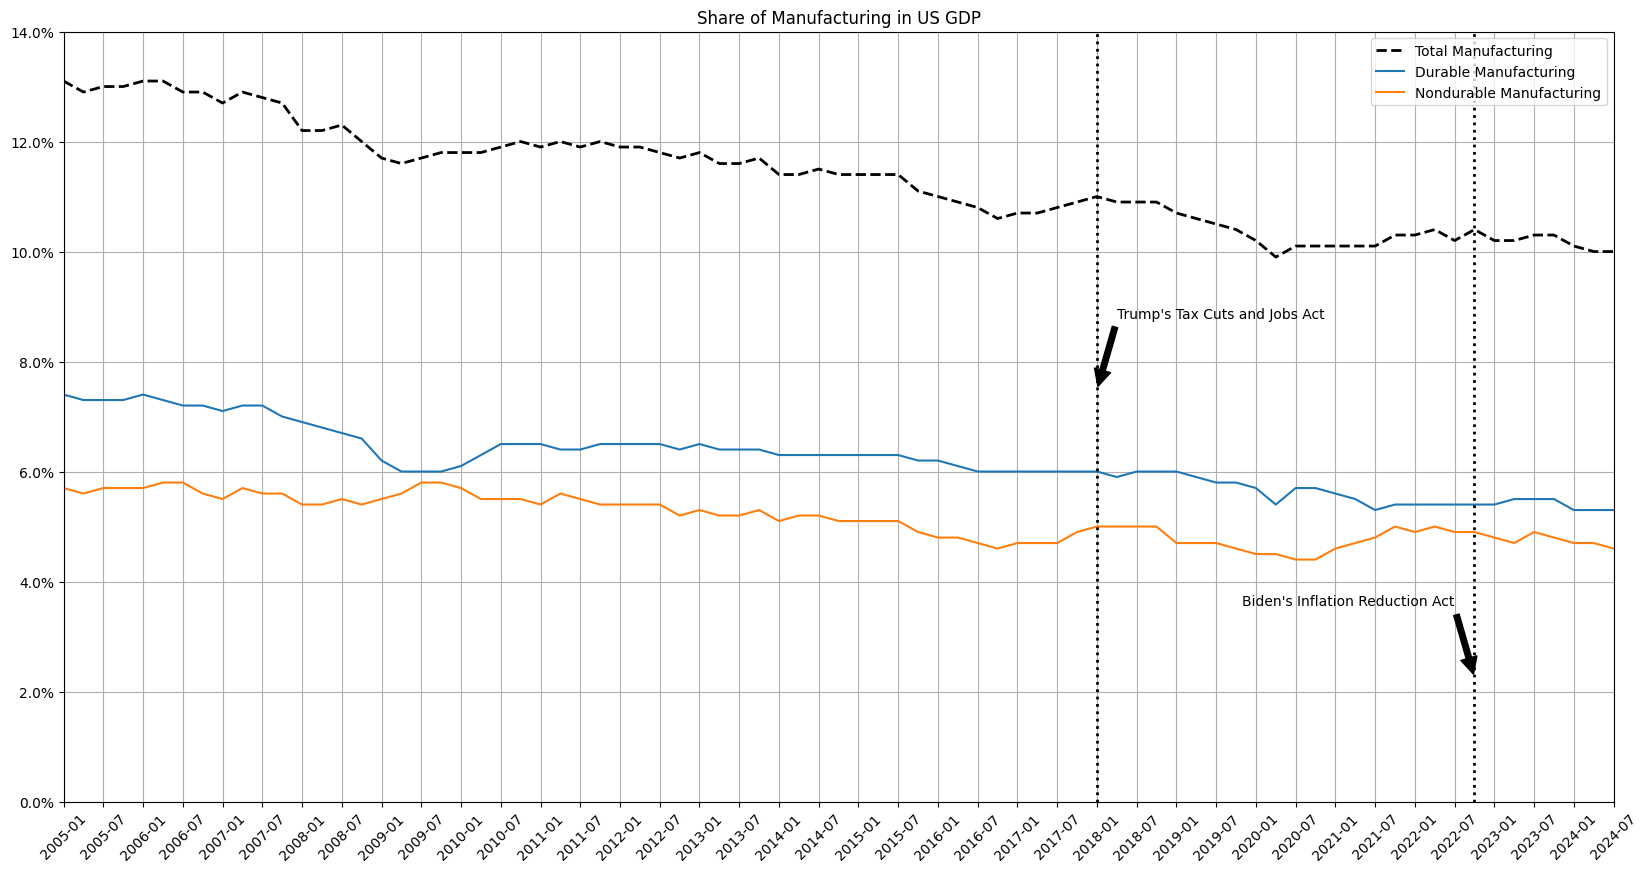

In [25]:
GRAPH_TITLE_MANUF_GDP_SHARE = 'Share of Manufacturing in US GDP'
ax = manuf_gdp_share.iloc[:,:1].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_MANUF_GDP_SHARE,
                                     xticks=manuf_gdp_share.index[::2], xlabel='', rot=45,
                                     linestyle='--', linewidth=2, color='k')
manuf_gdp_share.iloc[:,1:].plot(ax=ax, grid=True, xticks=manuf_gdp_share.index[::2], xlabel='', rot=45,
                                yticks=np.arange(0, .14, .02))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
x1 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(TAX_CUTS_DATE)]
y1 = manuf_gdp_share.iloc[:,0].max() / 1.75
x2 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(TAX_CUTS_DATE) + 1]
y2 = y1 + manuf_gdp_share.iloc[:,0].max() / 10
ax.axvline(x1, color='k', linestyle=':', linewidth=2)

x3 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(IRA_DATE)]
x4 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(IRA_DATE) - 1]
y3 = indpro_gdp_share.iloc[:,0].max() / 7.5
y4 = y3 + manuf_gdp_share.iloc[:,0].max() / 10
ax.axvline(x3, color='k', linestyle=':', linewidth=2)

ax.annotate('Trump\'s Tax Cuts and Jobs Act',
            xy=(x1, y1), xytext=(x2, y2),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Biden\'s Inflation Reduction Act',
            xy=(x3, y3), xytext=(x4, y4),
            arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right')
ax.legend(loc='upper right')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, manuf_gdp_share.index[::2])))

### Annual Percentage Changes in Components of Manufacturing Industry Group

In [26]:
ipman_components = web.get_data_fred(['IPDMAN', 'IPNMAN', 'IPGMFOS'], start=report_start, end=report_end)

# Measuring growth YTD in manufacturing with the corresponding intervals in previous years.
month = ipman_components.index[-1].month
ipman_components_ytd = ipman_components.loc[ipman_components.index.month <= month]
ipman_components_ytd = ipman_components_ytd.resample('YS-JAN').sum().pct_change().dropna()

# Converting to annual percentage changes (changes from the corresponding month a year ago)
ipman_components.update(ipman_components.pct_change(12))
ipman_components = ipman_components.loc['2003':]
ipman_components = pd.concat([indpro_components.iloc[:,1], ipman_components], axis=1)

In [27]:
IPDMAN_COLUMN_NAME = 'Durable Manufacturing Annual Percentage Change'
IPNMAN_COLUMN_NAME = 'Non-Durable Manufacturing Annual Percentage Change'
IPGMFOS_COLUMN_NAME = 'Other Manufacturing Annual Percentage Change'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'Annual Percentage Changes in Main Components of US Manufacturing'
ipman_components.rename(
    columns={'IPDMAN': IPDMAN_COLUMN_NAME, 'IPNMAN': IPNMAN_COLUMN_NAME,
             'IPGMFOS': IPGMFOS_COLUMN_NAME},
    inplace=True)
ipman_components_ytd.rename(
    columns={'IPDMAN': IPDMAN_COLUMN_NAME, 'IPNMAN': IPNMAN_COLUMN_NAME,
             'IPGMFOS': IPGMFOS_COLUMN_NAME},
    inplace=True)

In [28]:
ipman_components.loc['2020-01':]

,Manufacturing Annual Percentage Change,Durable Manufacturing Annual Percentage Change,Non-Durable Manufacturing Annual Percentage Change,Other Manufacturing Annual Percentage Change
DATE,,,,
2020-01-01,-1.8166%,-2.8162%,-0.8891%,0.8878%
2020-02-01,-1.1385%,-2.0158%,-0.1716%,-1.4213%
2020-03-01,-5.4862%,-8.9958%,-1.4823%,-7.0543%
2020-04-01,-19.5173%,-27.6978%,-10.2918%,-20.3922%
2020-05-01,-16.0354%,-22.3819%,-8.8112%,-18.0388%
...,...,...,...,...
2024-08-01,-0.1373%,-0.6527%,0.4957%,-2.4480%
2024-09-01,-0.6039%,-1.3427%,0.3215%,-4.2247%
2024-10-01,-0.6005%,-1.4772%,0.5746%,-6.7011%


#### Growth in manufacturing YTD
Here I compare the growth over the past months of the current year with the corresponding period of the previous year. Has the IRA had effect on industrial production? It has to some extent. The IRA benefits durable manufacturing and it has been growing, as you can see below.

In [29]:
ipman_components_ytd.loc['2020-01':]

,Durable Manufacturing Annual Percentage Change,Non-Durable Manufacturing Annual Percentage Change,Other Manufacturing Annual Percentage Change
DATE,,,
2020-01-01,-8.8638%,-3.8932%,-7.7797%
2021-01-01,6.0825%,3.8753%,2.8894%
2022-01-01,4.0022%,1.4514%,0.6672%
2023-01-01,0.1504%,-0.8972%,-6.7641%
2024-01-01,-1.0070%,0.2303%,-4.6859%


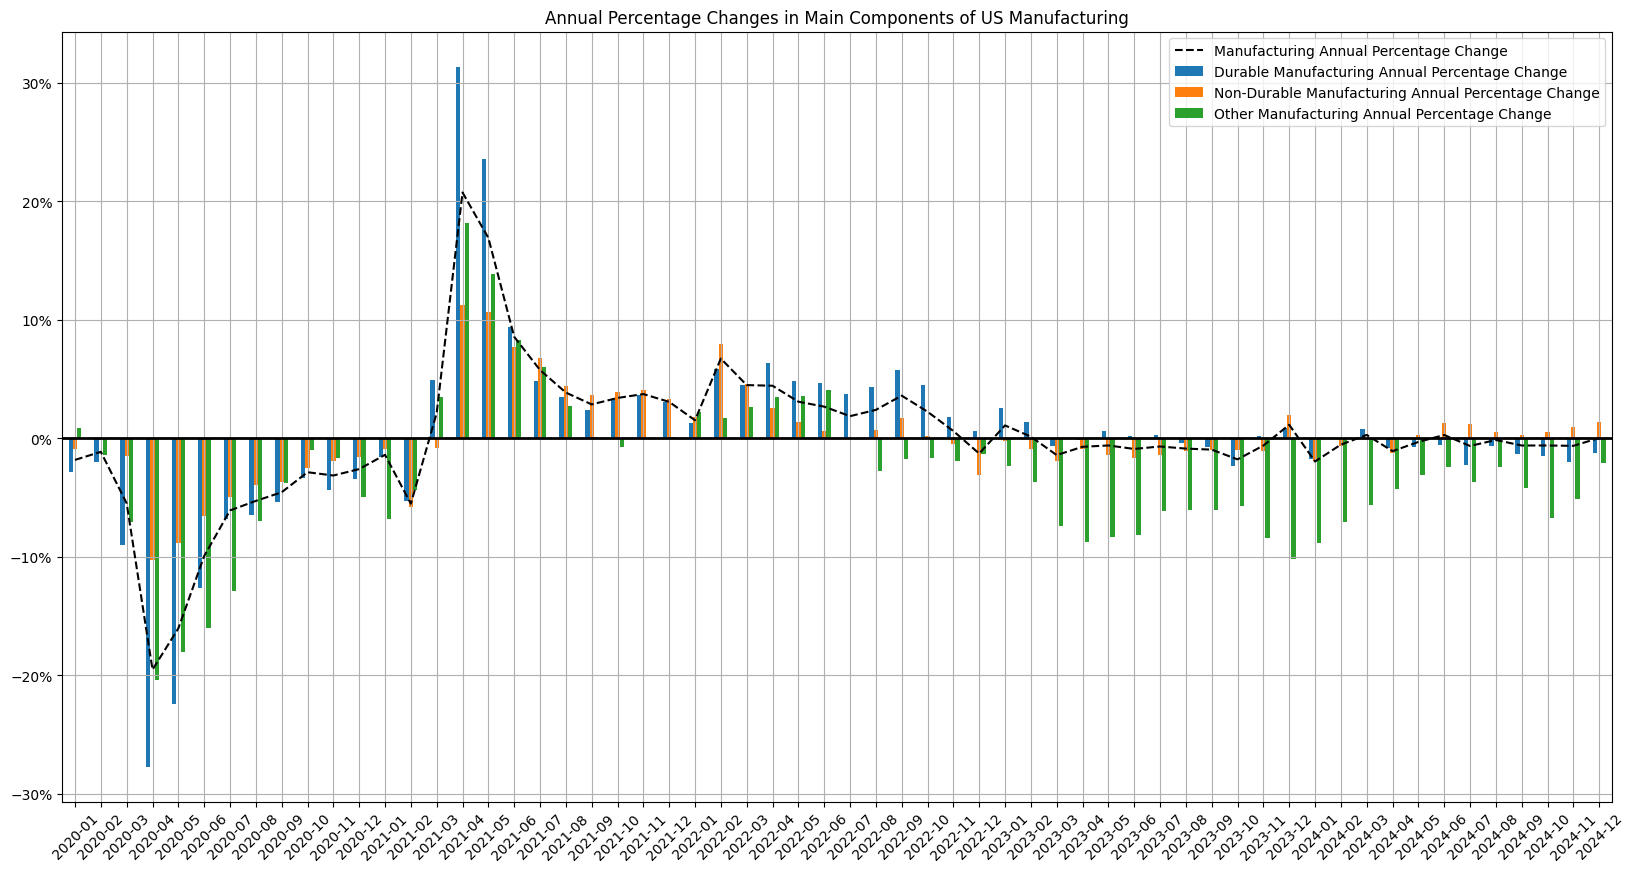

In [30]:
dt_from = date(2020, 1, 1)
ipman_components = ipman_components.loc[dt_from:]
ax = ipman_components.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
ipman_components.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipman_components.index)))

### Capacity Utilization in Manufacturing

In [31]:
indman_utilization = web.get_data_fred(['CAPUTLGMFDS', 'CAPUTLGMFNS', 'CAPUTLGMFOS'], start=report_start, end=report_end) / 100.
dt_from = date(2018, 1, 1)
indman_utilization = pd.concat([indpro_utilization.iloc[:, 1], indman_utilization.loc[dt_from:]], axis=1)

In [32]:
IPDMAN_CU_COLUMN_NAME = 'Durable Manufacturing Capacity Utilization'
IPNMAN_CU_COLUMN_NAME = 'Non-Durable Manufacturing Capacity Utilization'
IPGMFOS_CU_COLUMN_NAME = 'Other Manufacturing Annual Capacity Utilization'
GRAPH_TITLE_INDMAN_CU = 'Capacity Utilization in US Manufacturing'
indman_utilization.rename(
    columns={'CAPUTLGMFDS': IPDMAN_CU_COLUMN_NAME, 'CAPUTLGMFNS': IPNMAN_CU_COLUMN_NAME,
             'CAPUTLGMFOS': IPGMFOS_CU_COLUMN_NAME},
    inplace=True)

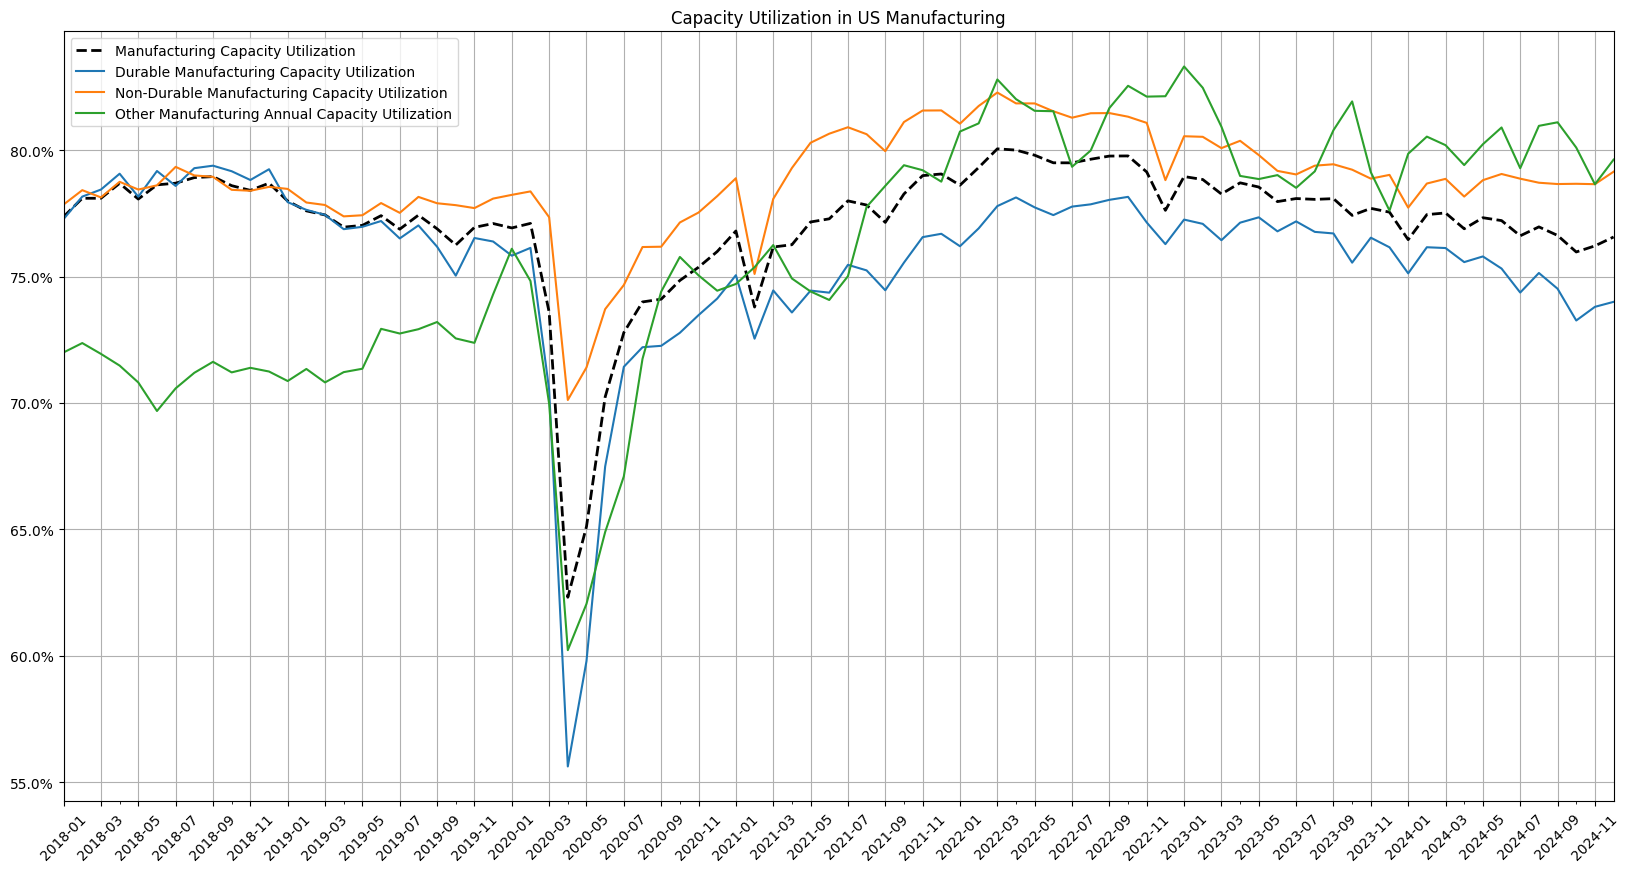

In [33]:
ax = indman_utilization.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDMAN_CU,
             xticks=indman_utilization.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indman_utilization.iloc[:,1:].plot(ax=ax, grid=True, xticks=indman_utilization.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indman_utilization.index[::2])))

## Labor productivity in Manufacturing

In [34]:
labor_prod = web.get_data_fred('OPHMFG', start=report_start, end=report_end).iloc[:,0]
_ = labor_prod.rename('Manufacturing Sector', inplace=True)

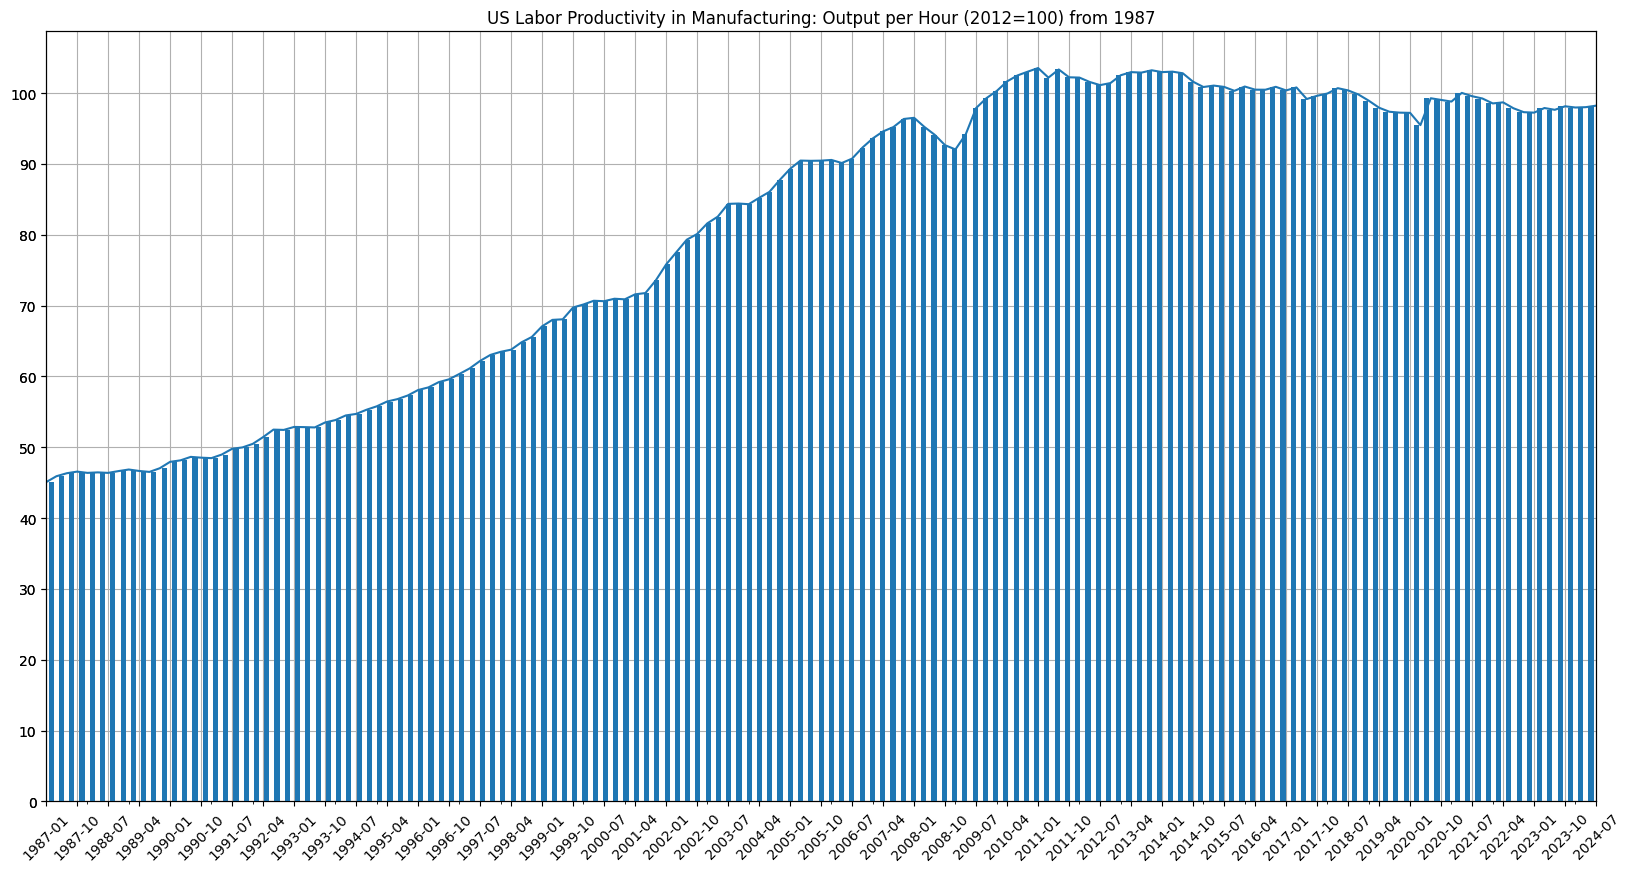

In [35]:
ax = labor_prod.plot(figsize=(20,10), grid=True, yticks=range(0, 130, 10),
                     title=GRAPH_TITLE_LABOR_PROD + ' from %d' % labor_prod.index[0].year,
                     xticks=labor_prod.index[::3], xlabel='', rot=45)
ax2 = ax.twiny()
labor_prod.plot.bar(ax=ax2, xlabel='', legend=False)
# ax.legend()
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, labor_prod.index[::3])))

In [36]:
labor_prod_pct_chg = labor_prod.pct_change(4).dropna()

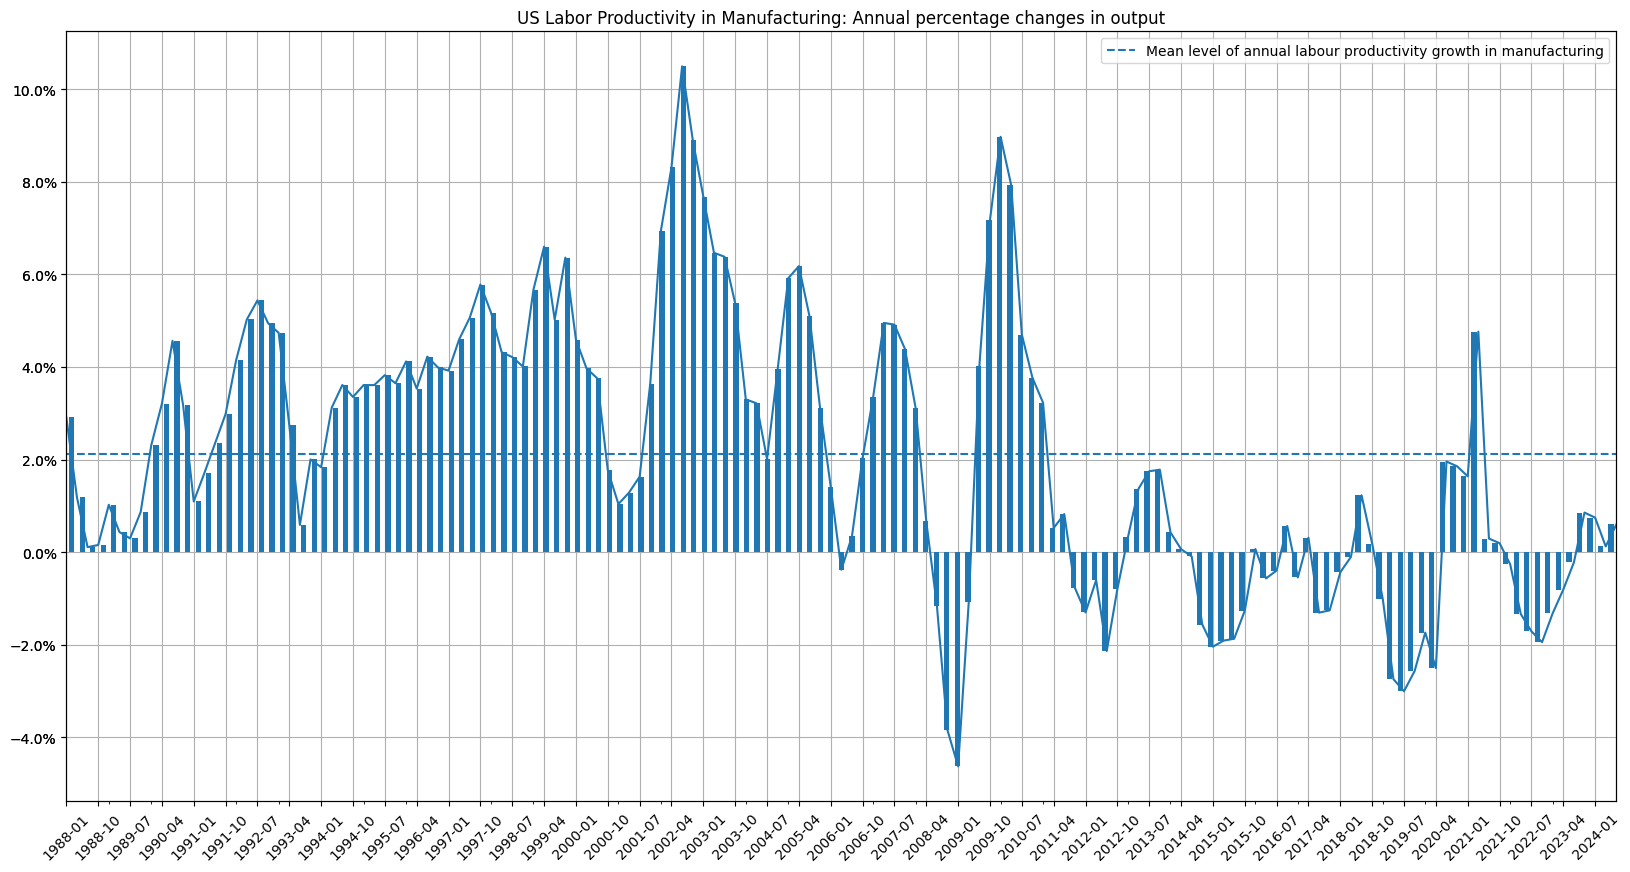

In [37]:
ax = labor_prod_pct_chg.plot(figsize=(20,10), grid=True,
                             title=GRAPH_TITLE_LABOR_PROD_PCT,
                             xticks=labor_prod_pct_chg.index[::3], xlabel='', rot=45)
ax2 = ax.twiny()
labor_prod_pct_chg.plot.bar(ax=ax2, xlabel='', legend=False)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
handle = ax.axhline(y=labor_prod_pct_chg.mean(), ls='--', c='#1f77b4', label=MEAN_LEVEL_OF_LABOR_PROD_PCT)
ax.legend(handles=[handle])
ax2.xaxis.set_major_locator(mtick.NullLocator())
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, labor_prod_pct_chg.index[::3])))

**Conclusion**: Labor productivity in US manufacturing clearly stopped growing consistently since 2011. Whether the current growth impulse will be persistent on the back of the IRA and the broader US industrial policy remains to be seen.

## Zooming in on the Durable Manufacturing Industry Group

In [38]:
ipdman_components = web.get_data_fred(['IPG321S', 'IPG327S', 'IPG331S', 'IPG332S', 'IPG333S',
                                       'IPG334S', 'IPG335S', 'IPG3361T3S', 'IPG3364T9S',
                                       'IPG337S', 'IPG339S'], start=report_start, end=report_end)
# dt_from_ipdman = date(1970, 1, 1)
# ipdman_components = ipdman_components.loc[dt_from_ipdman:]

In [39]:
IPDMAN_WP_COLUMN_NAME = 'Wood Products'
IPDMAN_NMMP_COLUMN_NAME = 'Nonmetallic Mineral Product'
IPDMAN_PM_COLUMN_NAME = 'Primary Metals'
IPDMAN_FMP_COLUMN_NAME = 'Fabricated Metal Products'
IPDMAN_M_COLUMN_NAME = 'Machinery'
IPNMAN_CEP_COLUMN_NAME = 'Computer and Electronic Products'
IPDMAN_EE_COLUMN_NAME = 'Electrical Equipment'
IPDMAN_MVP_COLUMN_NAME = 'Motor Vehicles and Parts'
IPDMAN_AS_COLUMN_NAME = 'Aerospace'
IPDMAN_F_COLUMN_NAME = 'Furniture'
IPDMAN_MSC_COLUMN_NAME = 'Miscellaneous'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'US Composition of Durable Manufacturing Industry Group'
GRAPH_TITLE_IPDMAN_COMPONENTS_PCT_CHG = 'Percentage Change in Output of Each Durable Manufacturing Industry Group'
ipdman_components.rename(
    columns={'IPG321S': IPDMAN_WP_COLUMN_NAME, 'IPG327S': IPDMAN_NMMP_COLUMN_NAME,
             'IPG331S': IPDMAN_PM_COLUMN_NAME, 'IPG332S': IPDMAN_FMP_COLUMN_NAME,
             'IPG333S': IPDMAN_M_COLUMN_NAME, 'IPG334S': IPNMAN_CEP_COLUMN_NAME,
             'IPG335S': IPDMAN_EE_COLUMN_NAME, 'IPG3361T3S': IPDMAN_MVP_COLUMN_NAME,
             'IPG3364T9S': IPDMAN_AS_COLUMN_NAME, 'IPG337S': IPDMAN_F_COLUMN_NAME,
             'IPG339S': IPDMAN_MSC_COLUMN_NAME},
    inplace=True)

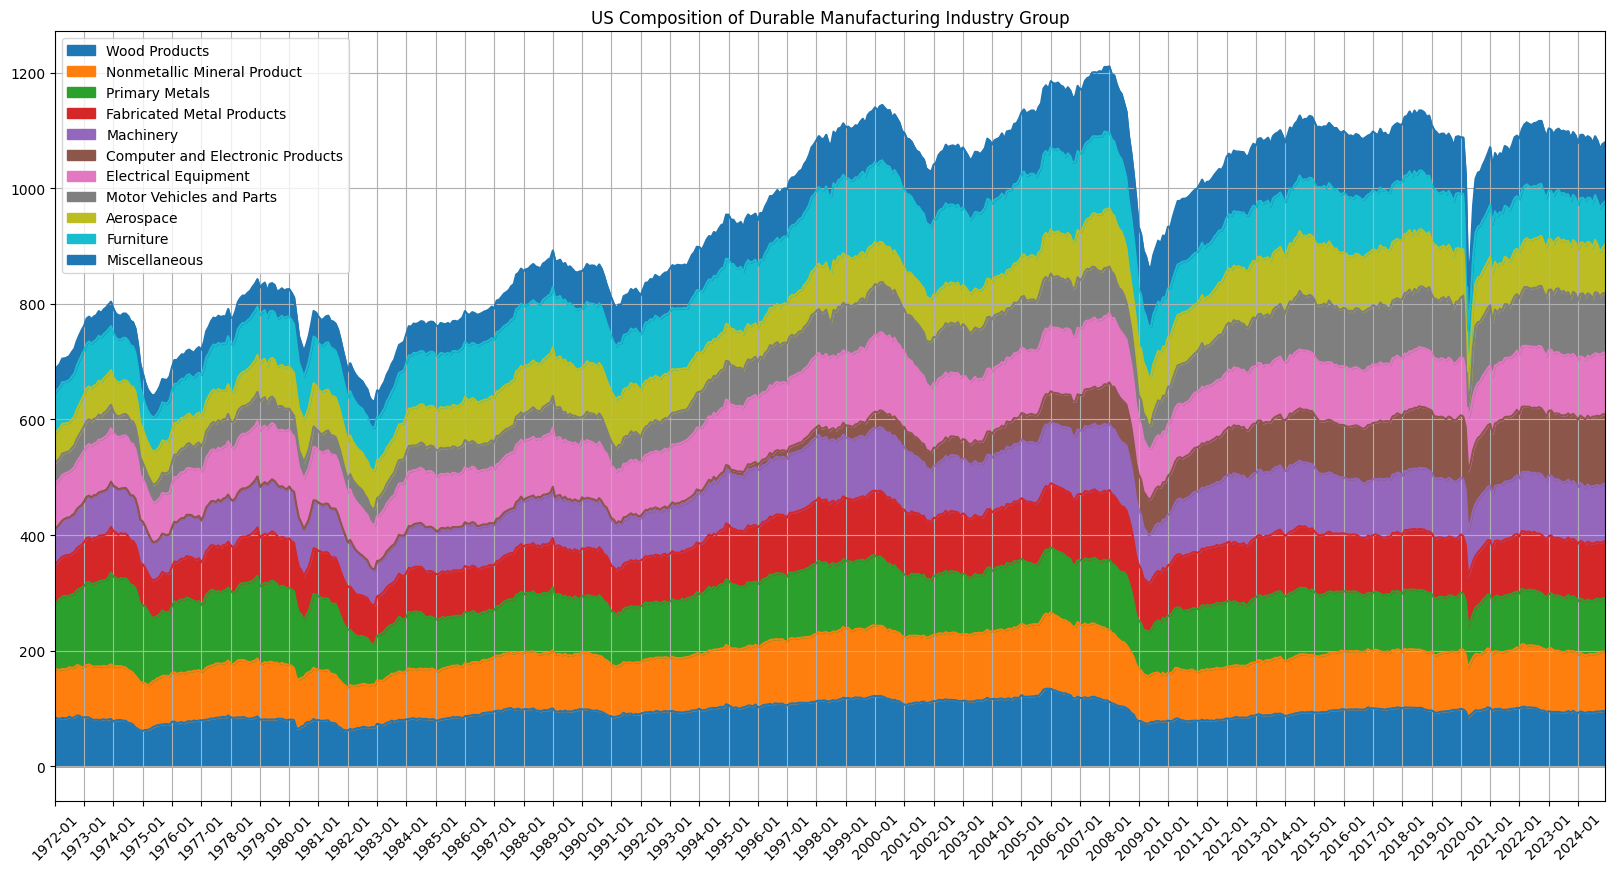

In [40]:
ax = ipdman_components.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                          xticks=ipdman_components.index[::12], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components.index[::12])))

In [41]:
# Converting to percentages by dividing by total
ipdman_components_pct = ipdman_components.divide(ipdman_components.sum(axis=1), axis=0)

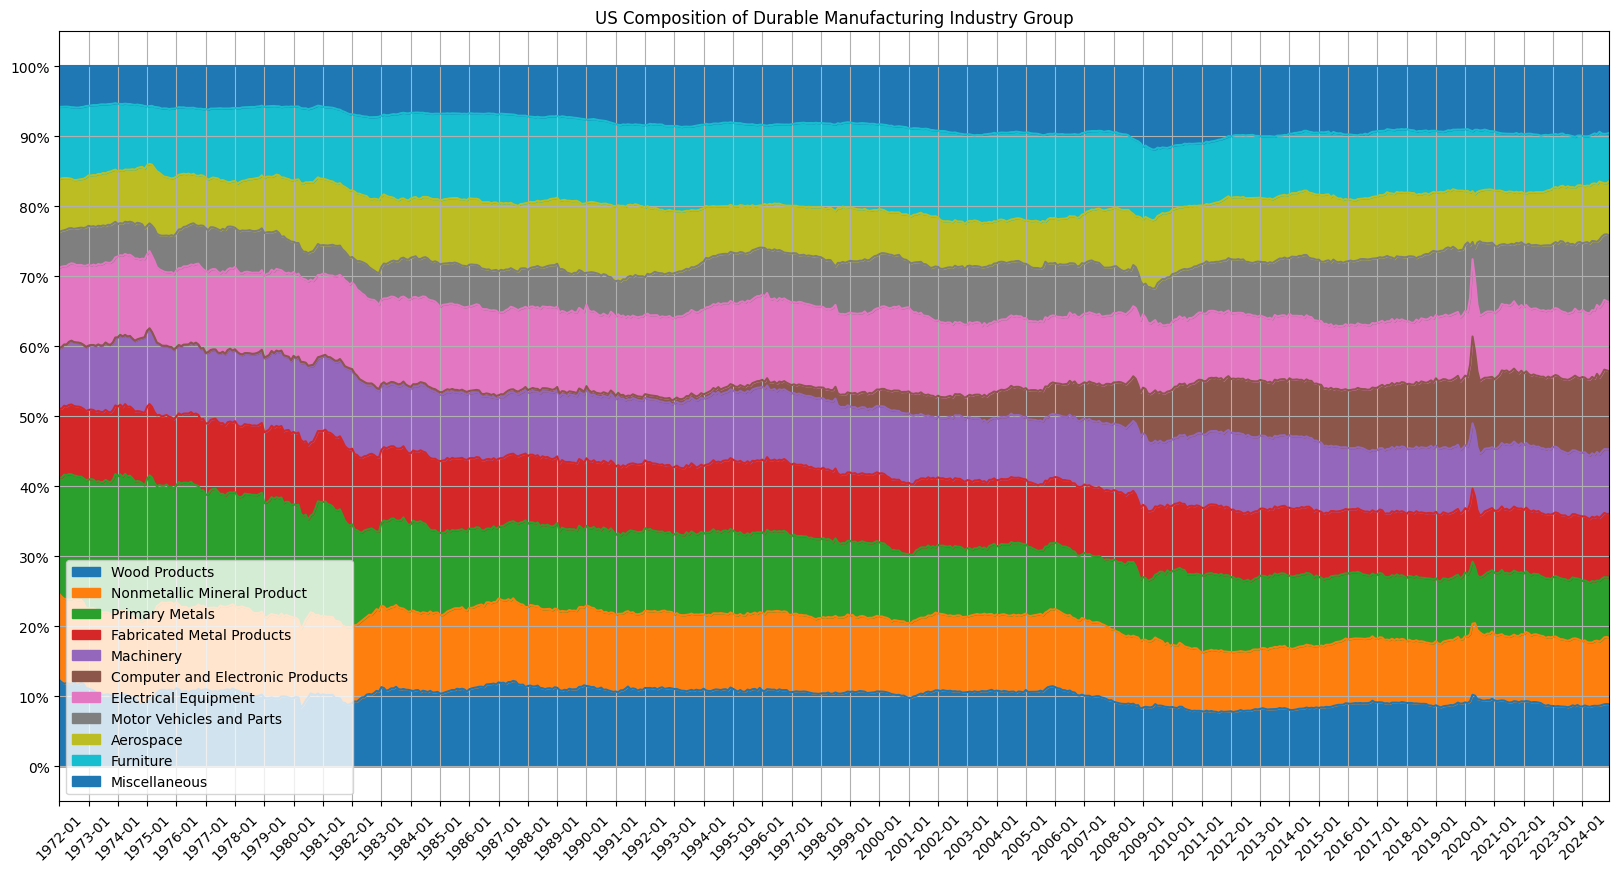

In [42]:
ax = ipdman_components_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                              xticks=ipdman_components_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components_pct.index[::12])))

### Percentage Changes in Output of Each Durable Manufacturing Industry Group
To see which durable manufacturing industry groups have grown or shrunk over a given period of time, I carry out additional analysis below. I limit it to reviewing changes over the past 5 and 10 years. I compare output per industry group over the last 12 months with that 5 and 10 years ago. This is more accurate than comparing the output in a given month with that same month 5 and 10 years ago.

In [43]:
periods = [10, 5]
ipdman_components_pct_chg = pd.concat(
    [ipdman_components.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods], axis=1)
ipdman_components_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

In [44]:
ipdman_components_pct_chg.sort_values(by=ipdman_components_pct_chg.columns[0], inplace=True)

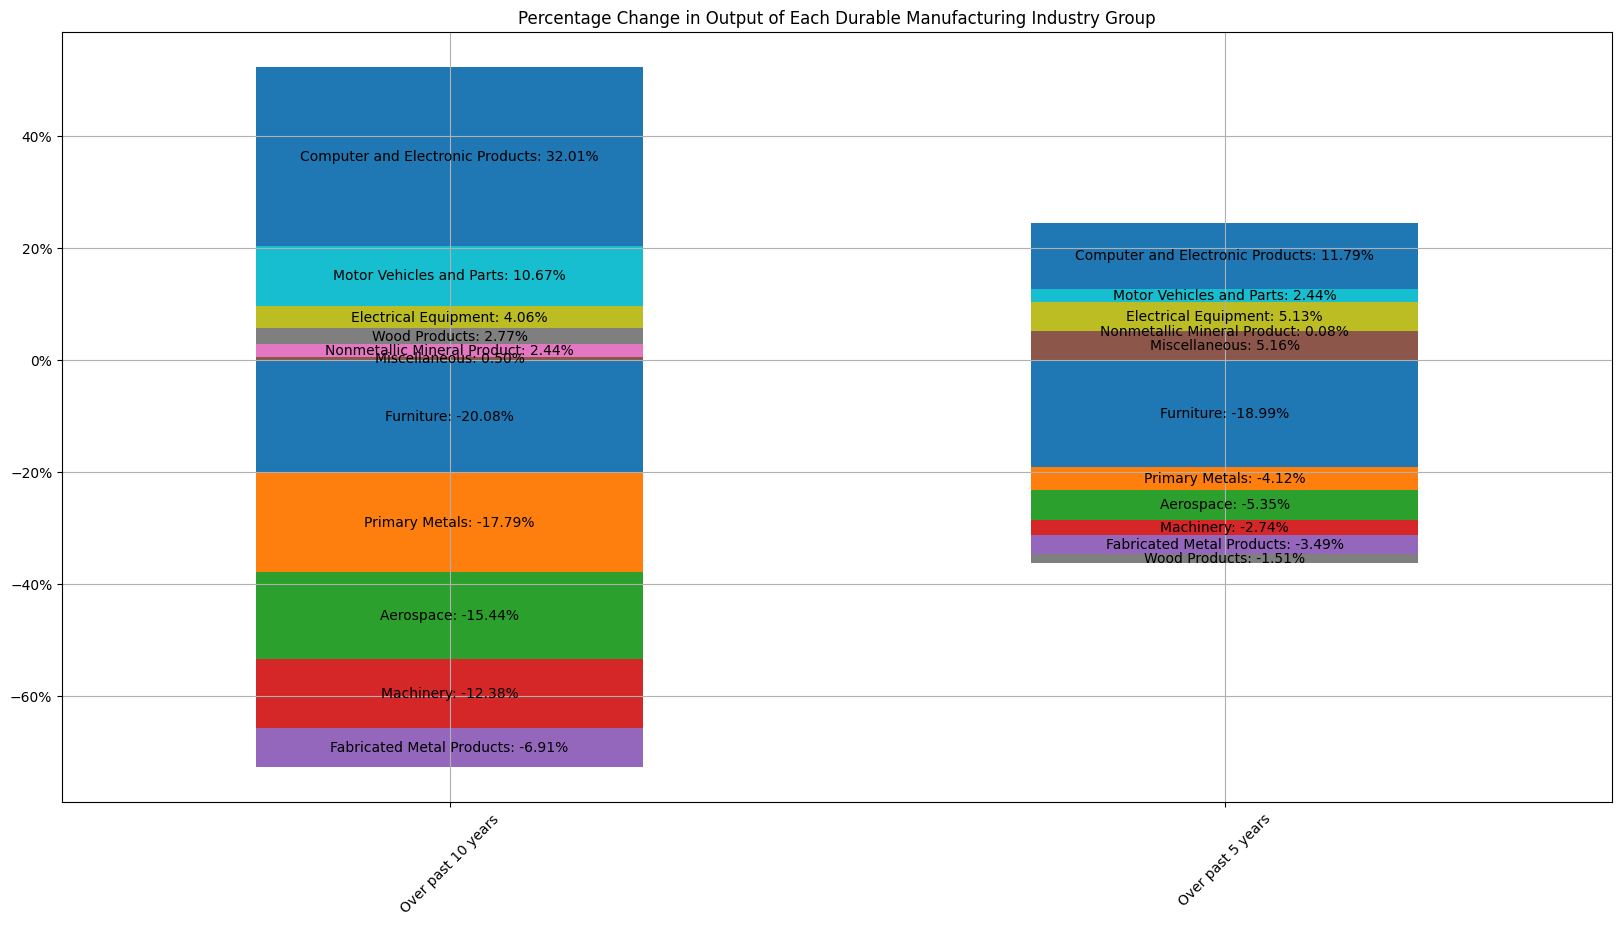

In [45]:
ax = ipdman_components_pct_chg.T.plot.bar(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS_PCT_CHG,
                                          stacked=True, rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')

### Percentage Changes in Output of Each Durable Manufacturing Industry Group YTD
And now the same analysis but only comparying cumuulative manufecturing output YTD with the corresponsing period of last year.

In [46]:
ipdman_components_ytd = ipdman_components.loc[ipdman_components.index.month <= month]
ipdman_components_ytd = ipdman_components_ytd.resample('YS-JAN').sum().pct_change().dropna()
ipdman_components_ytd.iloc[-1].sort_values()

Furniture                          -5.6572%
Nonmetallic Mineral Product        -4.5727%
Miscellaneous                      -2.2479%
Machinery                          -2.1625%
Aerospace                          -2.0360%
Primary Metals                     -1.6089%
Motor Vehicles and Parts           -1.5161%
Fabricated Metal Products          -0.7760%
Wood Products                      -0.0669%
Electrical Equipment                0.9056%
Computer and Electronic Products    4.0670%
Name: 2024-01-01 00:00:00, dtype: float64

### Overall percentage changes in output of durable manufacturing

In [47]:
ipdman = web.get_data_fred('IPDMAN', start=report_start, end=report_end)
ipdman_pct_chg = pd.concat([ipdman.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods],
                           axis=1)
ipdman_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

In [48]:
ipdman_pct_chg

,Over past 10 years,Over past 5 years
IPDMAN,-1.5950%,-0.3140%


## Zooming in on the Nondurable Manufacturing Industry Group

In [49]:
ipndman_components = web.get_data_fred(['IPG311A2S', 'IPG313A4S', 'IPG315A6S', 'IPG322S', 'IPG323S',
                                       'IPG324S', 'IPG325S', 'IPG326S'], start=report_start, end=report_end)

In [50]:
IPNDMAN_FBT_COLUMN_NAME = 'Food, Beverage, and Tobacco'
IPNDMAN_TP_COLUMN_NAME = 'Textiles and Products'
IPNDMAN_AL_COLUMN_NAME = 'Apparel and Leather Goods'
IPNDMAN_P_COLUMN_NAME = 'Paper'
IPNDMAN_PS_COLUMN_NAME = 'Printing and Related Support'
IPNDMAN_PCP_COLUMN_NAME = 'Petroleum and Coal Products'
IPNDMAN_C_COLUMN_NAME = 'Chemical'
IPNDMAN_PRP_COLUMN_NAME = 'Plastics and Rubber Products'
GRAPH_TITLE_IPNDMAN_COMPONENTS = 'US Composition of Nondurable Manufacturing Industry Group'
GRAPH_TITLE_IPNDMAN_COMPONENTS_PCT_CHG = 'Percentage Change in Output of Each Nondurable Manufacturing Industry Group'
ipndman_components.rename(
    columns={'IPG311A2S': IPNDMAN_FBT_COLUMN_NAME, 'IPG313A4S': IPNDMAN_TP_COLUMN_NAME,
             'IPG315A6S': IPNDMAN_AL_COLUMN_NAME, 'IPG322S': IPNDMAN_P_COLUMN_NAME,
             'IPG323S': IPNDMAN_PS_COLUMN_NAME, 'IPG324S': IPNDMAN_PCP_COLUMN_NAME,
             'IPG325S': IPNDMAN_C_COLUMN_NAME, 'IPG326S': IPNDMAN_PRP_COLUMN_NAME},
    inplace=True)

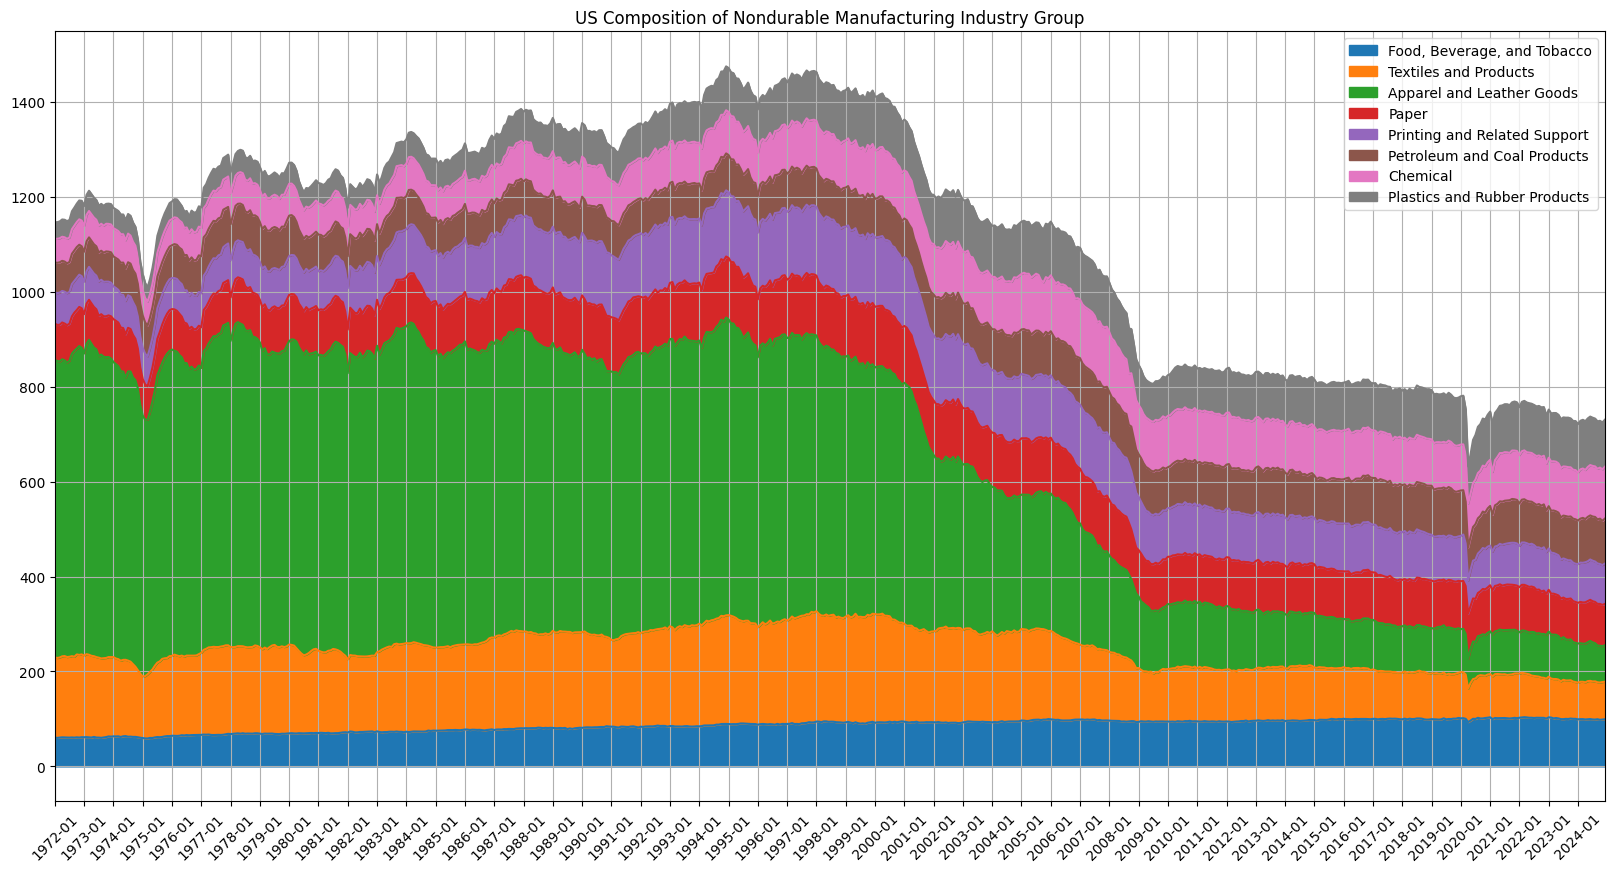

In [51]:
ax = ipndman_components.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPNDMAN_COMPONENTS,
                          xticks=ipdman_components.index[::12], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components.index[::12])))

In [52]:
# Converting to percentages by dividing by total
ipndman_components_pct = ipndman_components.divide(ipndman_components.sum(axis=1), axis=0)

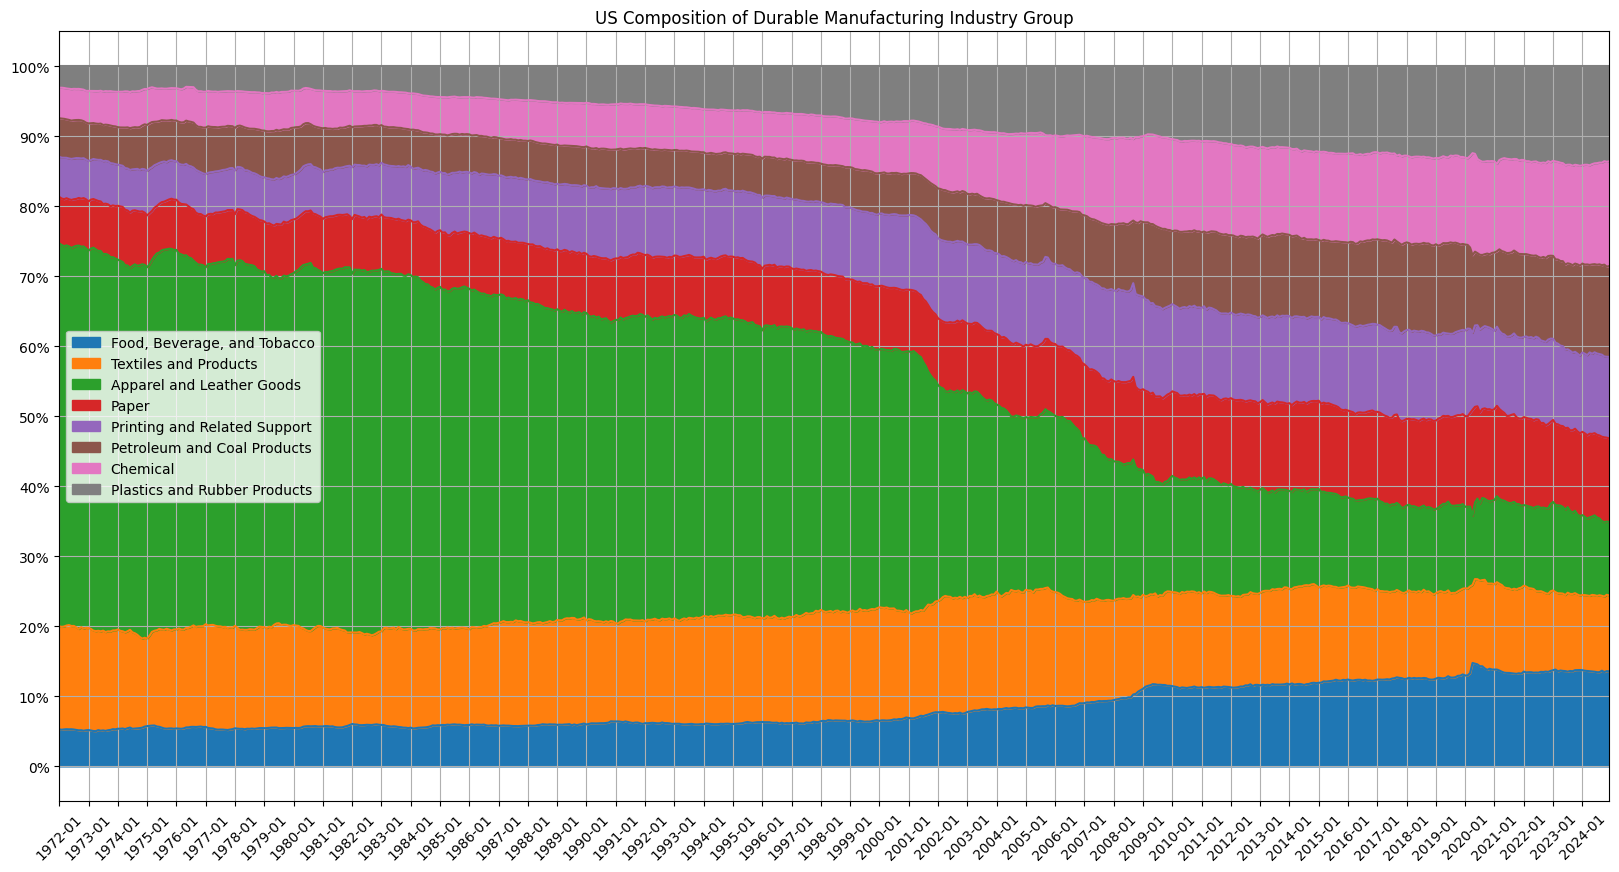

In [53]:
ax = ipndman_components_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                              xticks=ipndman_components_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipndman_components_pct.index[::12])))

### Percentage Changes in Output of Each Nondurable Manufacturing Industry Group
To see which nondurable manufacturing industry groups have grown or shrunk over a given period of time, I carry out additional analysis below. I limit it to reviewing changes over the past 5 and 10 years. I compare output per industry group over the last 12 months with that 5 and 10 years ago. This is more accurate than comparing the output in a given month with that same month 5 and 10 years ago.

In [54]:
ipndman_components_pct_chg = pd.concat(
    [ipndman_components.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods], axis=1)
ipndman_components_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

In [55]:
ipndman_components_pct_chg.sort_values(by=ipndman_components_pct_chg.columns[0], inplace=True)

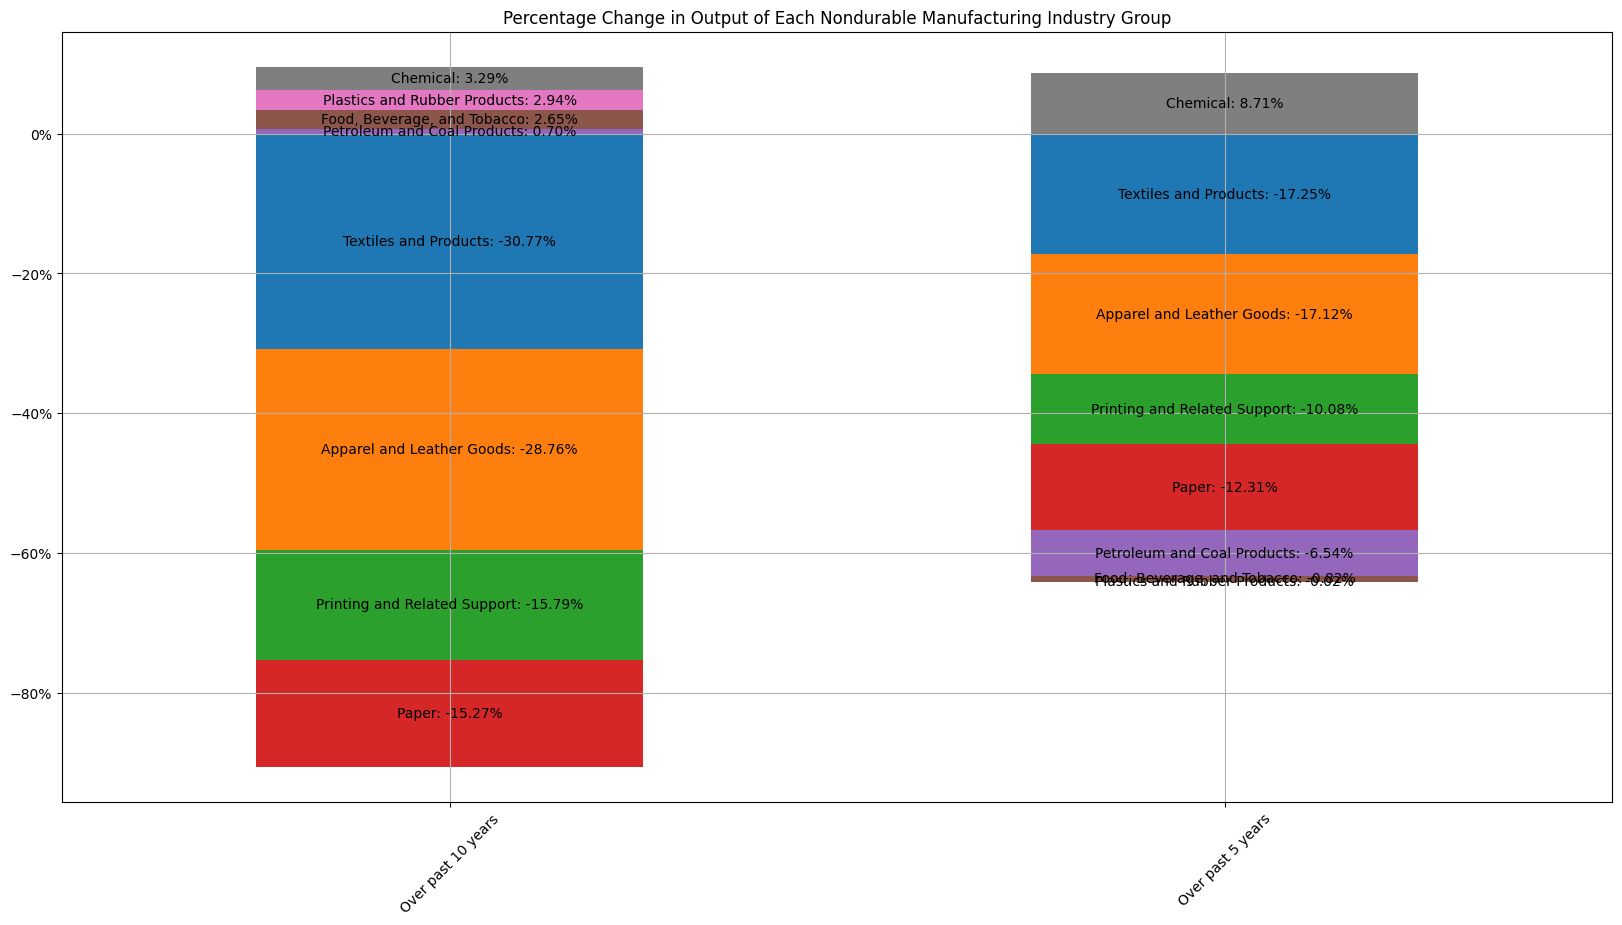

In [56]:
ax = ipndman_components_pct_chg.T.plot.bar(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPNDMAN_COMPONENTS_PCT_CHG,
                                           stacked=True, rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')

### Percentage Changes in Output of Each Nondurable Manufacturing Industry Group YTD
And now the same analysis but only comparying cumuulative manufecturing output YTD with the corresponsing period of last year.

In [57]:
ipndman_components_ytd = ipndman_components.loc[ipndman_components.index.month <= month]
ipndman_components_ytd = ipndman_components_ytd.resample('YS-JAN').sum().pct_change().dropna()
ipndman_components_ytd.iloc[-1].sort_values()

Apparel and Leather Goods      -10.1244%
Textiles and Products           -2.7247%
Food, Beverage, and Tobacco     -1.7875%
Plastics and Rubber Products    -1.5473%
Printing and Related Support     0.9940%
Paper                            1.3875%
Chemical                         1.9353%
Petroleum and Coal Products      2.9058%
Name: 2024-01-01 00:00:00, dtype: float64

### Overall percentage changes in output of nondurable manufacturing

In [58]:
ipnman = web.get_data_fred('IPNMAN', start=report_start, end=report_end)
ipnman_pct_chg = pd.concat([ipnman.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods], axis=1)
ipnman_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

In [59]:
ipnman_pct_chg

,Over past 10 years,Over past 5 years
IPNMAN,-0.0442%,0.6026%
